<a href="https://colab.research.google.com/github/andresC98/NescienceNNClassifier/blob/master/Dev_Nescience_NNC_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File imports

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving fashion-mnist_test.csv to fashion-mnist_test (1).csv
Saving fashion-mnist_train.csv to fashion-mnist_train (1).csv
User uploaded file "fashion-mnist_test.csv" with length 22176691 bytes
User uploaded file "fashion-mnist_train.csv" with length 133047193 bytes


In [2]:
!ls

'fashion-mnist_test (1).csv'    fashion-mnist_train.csv   pulsar_stars.csv
 fashion-mnist_test.csv         heart.csv		  sample_data
'fashion-mnist_train (1).csv'   hepatitis_csv.csv


#Nescience NN Classifier

In [0]:
#@title

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#########################################################
# Nescience Neural Network Classifier Notebook version  #
#########################################################



"""

Building optimal neural networks based on the minimum nescience principle

@author: Rafael Garcia Leiva
@mail:   rgarcialeiva@gmail.com
@web:    http://www.mathematicsunknown.com/
@copyright: All rights reserved
@version: 0.1 (13 Feb, 2018)

The following internal attributes will be used

    * X          - predictive features
    * y          - target variable
    
    * nu         - number of units per hidden layer
      
    * ni         - number of iterations
    * lr         - learning rate

    * method     - method to copute nescience
    * compressor - compression algorithm used to compute redundancy
    * verbose    - print debugging information

"""

import math
import numpy  as np
import pandas as pd
import collections
import time , sys
from random import randint

# Compression algorithms
import bz2
import lzma
import zlib

# Scikit-learn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

# Keras 
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras import losses
from keras.utils import to_categorical
from keras import backend as K

from queue import Queue

queue = Queue(10)
import os
import tensorflow as tf

class NescienceNeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    
    global queue
    
    # Constants defintion
    
    INVALID_INACCURACY = -1    # If algorithm cannot be applied to this dataset
    INVALID_REDUNDANCY = -2    # Too small model    
    
    def __init__(self, niterations=25, learning_rate=0.01, method="Harmonic", compressor="bz2", backward=False, verbose=False):
        """
        Initialization of the model
    
          * method:  String. Select the method to compute the nescience of the
                     tree, valid values are "Euclid", "Harmonic", "Geometric",
                     "Entropy" and "Inner"
          * niterations: Int. Maximum number of iterations used during the
                         training of the neural network
          * verbose:     Boolean. If true, prints out additional information
        """
       
        # TODO: check the input parameters
        
        self.nu = [3]   # Start with one hidden layer with three units

        self.it         = niterations
        self.lr         = learning_rate

        self.method     = method
        self.compressor = compressor
        self.backward   = backward
        self.verbose    = verbose
        
        self.X    = None
        self.y    = None
        self.nsc  = None
        self.msd  = None
        self.viu  = None
        
        self.classes_  = None
        self.n_classes = None

        self.tol   = 0.05 #originally at 0.05
        self.decay = 0.1 #originally at 0.1

        self.history = None #Records history of Stats for each algorithm' saved NN
        self.model_hist = None #dataframe with history

    def fit(self, X, y, run_until = 0):
        """
        Fit a model (a neural network with a hidden layer) given a dataset
    
        The input dataset has to be in the following format:
    
           * X = list([[x11, x12, x13, ...], ..., [xn1, xn2, ..., xnm]])
           * y = list([y1, ..., yn])
       
        Return the fitted model
        """
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
        # TODO: check the input parameters [DONE ?]
        if(len(X.shape) != 2 or len(y.shape) != 1):
            print("Invalid data shape/s of {} and output of {}.\nInput Array must be of format [[x11, x12, x13, ...], ..., [xn1, xn2, ..., xnm]].\nOutput array must be of format:[y1, ..., yn]".format(X.shape, y.shape))
            return
            #TODO Exit program?

        # TODO: test_size should be large enought, not a percentage of data
#         self.X, self.X_test, self.y, self.y_test = train_test_split(X, y, test_size=0.3)

#         self.X      = np.array(self.X)
#         self.X_test = np.array(self.X_test)
#         self.y      = np.array(self.y)
#         self.y_test = np.array(self.y_test)
           
        self.X = np.array(X)
        self.y = np.array(y)
        #validation splits will be done in each .fit automatically.
        #added smth
        self.classes_  = np.unique(y)
        self.n_classes = self.classes_.shape[0]

        self.history = [] #no need to be a synchr. queue as it wont be used for real-time graphs 

        #time metrics
        start_time = time.time()

        # Compute the contribution of each feature to miscoding
        
        #self._initmiscod() #substitute by tcc
        self.msd = self._tcc() #updated method
        
        if self.backward:
            self.viu = np.ones(self.X.shape[1], dtype=np.int)
        else:
            self.viu = np.zeros(self.X.shape[1], dtype=np.int)

        # Create the initial neural network
        #  - two features
        #  - one hidden layer
        #  - three units

        #Idea: check total # of features of dataset. Initial network will have input variables
        #   depending of this number of features, to avoid slow start & stuck.
        init_ft_space = int(np.ceil(X.shape[1]/8))
        self.nu[0] = init_ft_space
        #msd = self.msd.copy()        
        print("Will start with {} features out of {}.".format(init_ft_space, X.shape[1]))
        
        if self.backward:
            self.viu[np.where(self.msd == np.max(self.msd))] = 0
        else:            
            self.viu[np.where(self.msd == np.min(self.msd))] = 1
            
        if self.backward:
            self.msd[np.where(self.viu == 0)] = 0
        else:
            self.msd[np.where(self.viu)] = 1

        
        for i in np.arange(init_ft_space-1): 
            
            if self.backward:
                self.msd[np.where(self.viu == 0)] = 0
            else:
                self.msd[np.where(self.viu)] = 1

            if self.backward:
                self.viu[np.where(self.msd == np.max(self.msd))] = 0
            else:
                self.viu[np.where(self.msd == np.min(self.msd))] = 1
        
        msdX = self.X[:,np.where(self.viu)[0]]
        print("Input dimension: {}".format(msdX.shape[1]))
        #Initial NN construction
        self.nn = Sequential()
        self.nn.add(Dense(units = self.nu[0], activation='relu', input_dim=msdX.shape[1]))
        self.nn.add(Dense(units = self.n_classes, activation = 'softmax'))
        #adam = optimizers.Adam(lr=self.lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        sgd = optimizers.SGD(lr = self.lr, momentum = 0.9,nesterov = True)
        self.nn.compile(loss = losses.categorical_crossentropy ,optimizer = sgd, metrics=['accuracy'])
        #while keras being tested with multiclass classification - softmax
        self.y = to_categorical(self.y) #to use with categorical cross entropy
#         self.y_test = to_categorical(self.y_test) #to use with categorical cross entropy
        
        #NN fit
        print("[DEBUG] Fitting initial NN.")
        self.nn.fit(x = msdX, y= self.y, validation_split=0.33,verbose=0,batch_size = 32, epochs = self.it)
        
        self.nn.summary()
        print("[DEBUG] Evaluating initial nn...")
        score = self.nn.evaluate(msdX, self.y)
        print("[DEBUG] Keras-Scores obtained: {}:{}, {}:{}.".format(self.nn.metrics_names[0],score[0],self.nn.metrics_names[1],score[1]))
        self.nsc = self._nescience(self.msd, self.viu, self.nn, msdX)
        
        if self.nsc == self.INVALID_INACCURACY:
            # There is anything more we can do with this dataset
            # since current model is already nearly perfect
            print("WARNING: Invalid Nescience")
            if self.verbose:
                print("Miscoding: ", self._miscoding(self.msd, self.viu), "Inaccuracy: ", self._inaccuracy(self.nn, msdX), "Redundancy: ", self._redundancy(self.nn), "Nescience: ", self._nescience(self.msd, self.viu, self.nn, msdX))
                print(self._cnn2str())
            return self
            
        if self.verbose:
            vals, queue = self._update_vals(msdX)
            print("Miscoding: ", vals["miscoding"], "Inaccuracy: ", vals["inaccuracy"], "Redundancy: ", vals["surfeit"], "Nescience: ", vals["nescience"])
        
        # While the nescience decreases
        decreased = True        
        iter = 0
        while (decreased):
            iter+=1
            print("Run #{}.".format(iter))
            if(run_until != 0 and iter > run_until):
                print("Stopped algorithm, max runs achieved.")
                break
            decreased = False

            #
            # Test adding a new feature  
            #
            
            # Check if therer are still more variables to add
            if (self.backward and (np.sum(self.viu) != 0)) or \
               ((not self.backward) and (np.sum(self.viu) != self.viu.shape[0])):
            
                msd = self.msd.copy()
                viu = self.viu.copy()
            
                if self.backward:
                    msd[np.where(viu == 0)] = 0
                else:
                    msd[np.where(viu)] = 1

                if self.backward:
                    viu[np.where(msd == np.max(msd))] = 0
                else:
                    viu[np.where(msd == np.min(msd))] = 1

                msdX = self.X[:,np.where(viu)[0]]
                #New Keras NN creation
                print("[DEBUG] Testing adding a new feature to cnn. {} nº of features.".format(msdX.shape[1]))
                init_t = time.time()

                cnn = Sequential() #network has to be created from scratch, we cannot reuse weights
                cnn.add(Dense(units = self.nu[0], activation='relu', input_dim=msdX.shape[1])) #first layer after inputs
                for layer in np.arange(len(self.nu)-1):
                    cnn.add(Dense(units = self.nu[layer+1], activation = 'relu'))
                cnn.add(Dense(units = self.n_classes, activation = 'softmax'))
                # adam = optimizers.Adam(lr=self.lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
                sgd = optimizers.SGD(lr = self.lr, momentum = 0.9, nesterov = True)
                cnn.compile(loss = losses.categorical_crossentropy ,optimizer = sgd, metrics=['accuracy'])
                cnn.fit(x = msdX, y= self.y,validation_split=0.33, verbose=0,batch_size = 32, epochs = self.it)

                network_comp_t = time.time() - init_t
                print("Took {:.2f}s. to create and fit test NN.".format(network_comp_t))
                
                nsc = self._nescience(self.msd, viu, cnn, msdX)
                if(nsc == 0):
                    break
                if nsc == self.INVALID_INACCURACY:
                    # We cannot do anything more with this dataset
                    self.nsc = nsc
                    self.nn  = cnn
                    self.viu = viu

                    if self.verbose:
                        vals, queue = self._update_vals(msdX)                     
                        print("Warning: invalid inaccuracy")
                        print("Miscoding: ", vals["miscoding"], "Inaccuracy: ", vals["inaccuracy"], "Redundancy: ", vals["surfeit"], "Nescience: ", vals["nescience"])

                    break
            
                # Save data if nescience has been reduced                        
                if (nsc - self.tol) < self.nsc:
                    print("DEBUG] Nescience reduced - SAVED THIS CONFIGURATION.")
                    cnn.summary()

                    decreased = True
                    self.nsc = nsc
                    self.nn   = cnn
                    self.viu  = viu
                    if self.verbose:
                        vals, queue = self._update_vals(msdX)
                        if self.backward:
                            print("Removed a feature. Var in use: ", np.sum(self.viu), " Nescience: ", nsc)
                        else:
                            print("Added new feature - Nescience: ", nsc)
                else:
                    pass
                    #K.clear_session()

            #
            # Test adding a new layer
            #
            
            nu = self.nu.copy()
            nu.append(3)
            # if(randint(0, 100) > 75):
            #     nu.append(2*int(np.ceil(np.mean(nu))))
            # else:
            #     nu.append(int(np.ceil(np.mean(nu))))
           
            print("[DEBUG] Testing adding a new layer... Current hidden layers: {}.".format(nu)) 

            msdX = self.X[:,np.where(self.viu)[0]]
            init_t = time.time()
            cnn = Sequential()
            cnn.add(Dense(units = nu[0], activation='relu', input_dim=msdX.shape[1]))
            for k, units in enumerate(nu):
                if(k > 0): #we already added the first hidden layer
                    cnn.add(Dense(units, activation = 'relu'))
            
            cnn.add(Dense(units = self.n_classes, activation = 'softmax'))
            #reusing weights from previous saved network's layers.
            # cnn = Sequential()
            # for layer in self.nn.layers[:-1]: # just exclude last layer from copying
            #     cnn.add(layer)
            # for layer in cnn.layers:
            #     layer.trainable = False #to reuse their weights

            # cnn.add(Dense(units = nu[-1], activation = 'relu')) #adding the extra layer
            # cnn.add(Dense(units = self.output_num, activation = 'softmax'))
            sgd = optimizers.SGD(lr = self.lr, momentum = 0.9,nesterov = True)
            # adam = optimizers.Adam(lr=self.lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
            cnn.compile(loss = losses.categorical_crossentropy ,optimizer = sgd, metrics=['accuracy'])
            cnn.fit(x = msdX, y= self.y, validation_split=0.33,verbose=0,batch_size = 32, epochs = self.it)
            
            network_comp_t = time.time() - init_t
            print("Took {:.2f}s. to create and fit test NN.".format(network_comp_t))

            nsc = self._nescience(self.msd, self.viu, cnn, msdX)
            if(nsc == 0):
                    break

            if nsc == self.INVALID_INACCURACY:
                    # We cannot do anything more with this dataset
                    self.nsc = nsc
                    self.nn  = cnn
                    self.nu  = nu

                    if self.verbose:
                        vals, queue = self._update_vals(msdX)
                        print("Warning: invalid inaccuracy")
                        print("Miscoding: ", vals["miscoding"], "Inaccuracy: ", vals["inaccuracy"], "Redundancy: ", vals["surfeit"], "Nescience: ", vals["nescience"])

                    break
            
            # Save data if nescience has been reduced                        
            if (nsc - self.tol) < self.nsc:
                print("DEBUG] SAVED THIS CONFIGURATION.")
                cnn.summary()
                self.nsc  = nsc
                self.nn   = cnn
                self.nu   = nu
                decreased = True
                
                if self.verbose:
                    vals, queue = self._update_vals(msdX)
                    print("Added new layer - Nescience: ", nsc)
            else:
                pass
                #K.clear_session()


            for i in np.arange(len(self.nu)): #loops k times (in a NN with K hidden layers)
                nu = self.nu.copy()
                # if(randint(0, 100) > 75):
                #     nu[i] = 2*nu[i]
                # else:
                #     nu[i] = nu[i] + 1 #extra node added to hidden layer i     
                nu[i] = nu[i] + 1 #extra node added to hidden layer i     
                print("[DEBUG] Testing adding a new unit... Hidden layers: {}".format(nu))            
                msdX = self.X[:,np.where(self.viu)[0]]
                
                init_t = time.time() 
                cnn = Sequential()
                cnn.add(Dense(units = nu[0], activation='relu', input_dim=msdX.shape[1]))
                for k in np.arange(len(self.nu)-1):
                    cnn.add(Dense(units = nu[k+1], activation='relu'))
                cnn.add(Dense(units = self.n_classes, activation = 'softmax'))
                sgd = optimizers.SGD(lr = self.lr, momentum = 0.9, nesterov = True)
                # adam = optimizers.Adam(lr= self.lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)   
                cnn.compile(loss = losses.categorical_crossentropy ,optimizer = sgd, metrics=['accuracy'])
                cnn.fit(x = msdX, y= self.y, validation_split=0.33,verbose=0,batch_size = 32, epochs = self.it)

                network_comp_t = time.time() - init_t
                print("Took {:.2f}s. to create and fit test NN.".format(network_comp_t))

                nsc = self._nescience(self.msd, self.viu, cnn, msdX)
                if(nsc == 0):
                    break
                if nsc == self.INVALID_INACCURACY:
                    # We cannot do anything more with this dataset
                    self.nsc = nsc
                    self.nu  = nu
                    self.nn  = cnn
                    # queue.put(self.nsc)
                    # TODO: Solve this problem
                    print("Warning! Panic! Warning! Panic! ...")
                    break
            
                # Save data if nescience has been reduced                        
                if (nsc - self.tol) < self.nsc: 
                    print("DEBUG] SAVED THIS CONFIGURATION.")
                    cnn.summary()
                    self.nsc  = nsc
                    self.nn   = cnn
                    self.nu   = nu
                    decreased = True

                    if self.verbose:
                        vals, queue = self._update_vals(msdX)
                        print("Added new unit - Nescience: ", nsc)
                        print("[DEBUG] Nescience has been reduced after adding new unit")
                else:
                    pass
                    #K.clear_session()

        
            # Update tolerance
            self.tol = self.tol * (1 - self.decay)
            print("Tolerance: " + str(self.tol))


        # -> end while
                        
        # Print out the best nescience achieved
        if self.verbose:
            
            if self.nsc == self.INVALID_INACCURACY:
                print("WARNING: Invalid Nescience")
            else:
                msdX = self.X[:,np.where(self.viu)[0]]
                print("Final -> Miscoding: ", self._miscoding(self.msd, self.viu), "Inaccuracy: ", self._inaccuracy(self.nn, msdX), "Redundancy: ", self._redundancy(self.nn), "Nescience: ", self._nescience(self.msd, self.viu, self.nn, msdX))

            print(self._nn2str(self.nn))
            self.nn.summary()
            elapsed_time = time.time() - start_time
            print("Total elapsed time for obtaining final network: {} s.".format(elapsed_time))

        print("Proceeding to test obtained network with whole dataset:")
        final_score = self.score(X[:,np.where(self.viu)[0]],to_categorical(y))
        print("Obtained final score of: {}.".format(final_score))

        time.sleep(2) #to make sure to log. 

        return self
 
    
    def predict(self, nn, X):
        """
        Predict class given a dataset
    
          * X = list([[x11, x12, x13, ...], ..., [xn1, xn2, ..., xnm]])
    
        Return a list of classes predicted
        """
        # TODO: Check that we have a model trained
        predictions = nn.predict(X) # Softmax output
        predictions = np.argmax(predictions, axis=1)
        #print("[DEBUG] Predictions after argmax interpretation: {}".format(predictions))
        return predictions


    def score(self, X, y):
        """
        Evaluate the performance of the current model given a test dataset

           * X = list([[x11, x12, x13, ...], ..., [xn1, xn2, ..., xnm]])
           * y = list([y1, ..., yn])
    
        Return one minus the mean error
        """
        
        # TODO: Check that we have a model trained>
        #Keras returns accuracy (mean accuracy). Is the same? (1-mean error === mean acc.)
        print("Input data shape: {}, Output data shape: {}.".format(X.shape, y.shape))
        print("Neural Network to test:")
        self.nn.summary()
        score = self.nn.evaluate(X, y, verbose=1)[1] #evaluate returns (loss, accuracy) tuple
        print("Obtained Network Evaluation Score of: {}".format(score))
        
        return score      

    
    """
    Compute the contribution of each feature to miscoding
    
    TODO: Somehow we should penalize non-contributing features
    """
    def _initmiscod(self):
         
        msd = list()

        for i in range(0, self.X.shape[1]):

            Pred = list(pd.cut(self.X[:,i], bins=100, labels=range(0, 100)))
            Resp = self.y
            Join =  list(zip(Pred, Resp))

            count_X  = collections.Counter(Pred)
            count_y  = collections.Counter(Resp)
            count_Xy = collections.Counter(Join)
    
            tot_X = self.X.shape[0]

            ldm_X  = 0
            for key in count_X.keys():
                ldm_X = ldm_X + count_X[key] * ( - np.log2(count_X[key] / tot_X))
    
            ldm_y  = 0
            for key in count_y.keys():
                ldm_y = ldm_y + count_y[key] * ( - np.log2(count_y[key] / len(self.y)))

            ldm_Xy  = 0
            for key in count_Xy.keys():
                ldm_Xy = ldm_Xy + count_Xy[key] * ( - np.log2(count_Xy[key] / len(self.y)))
       
            K_yX = ldm_Xy - ldm_X
            # K_Xy = ldm_Xy - ldm_y
    
            # TODO: It should be something like:
            # mscd = max(K_yX, K_Xy) / max(ldm_X, ldm_y) / self.X.shape[1]
            
            mscd = K_yX / ldm_y 

            msd.append(mscd)

        # self.msd = np.array(msd) / np.sum(msd)
        self.msd = np.array(msd)
        return    

    
    """
    Compute the miscoding of the dataset used by the current model
      
    Return the miscoding
    """
    def _miscoding(self, msd, viu):
        
        mean = np.mean(msd)
        mmsd = mean - msd
        mmmsd = np.zeros(len(msd))
        
        mmmsd[np.where(mmsd > 0)] = mmsd[np.where(mmsd > 0)] / np.sum(mmsd[np.where(mmsd > 0)])
        mmmsd[np.where(mmsd < 0)]  = mmsd[np.where(mmsd < 0)] / np.abs(np.sum(mmsd[np.where(mmsd < 0)]))

        # miscoding = np.abs(1 - np.sum(np.multiply(1/len(self.viu) - msd, viu)))
        # miscoding = np.sum(np.multiply(msd, viu))
        miscoding = 1 - np.sum(np.multiply(mmmsd, viu))
                    
        return miscoding
 
    
    """
    Compute inaccuracy the current tree

    Warning: If the inaccuracy is a negative number it should not be used

    TODO: Perhaps I should add y[i] to the error string
      
    Return the inaccuracy
    """
    def _inaccuracy(self, nn, X):
                        
        # Compute the list of errors
        
        pred = self.predict(nn, X)
        
        error = list()
        #print("[DEBUG] Y shape: {}, Pred shape: {}".format(self.y.shape, pred.shape))
        
        for i in range(X.shape[0]):
            if pred[i] != np.argmax(self.y, axis=1)[i]:
                error.append(list(X[i,:]))

        # Compute the length of the encoding of the error
        error  = str(error).encode()
        
        if self.compressor == "lzma":
            dmodel = lzma.compress(error, preset=9)
        elif self.compressor == "zlib": 
            dmodel = zlib.compress(error, level=9)
        else: # By default use bz2   
            dmodel = bz2.compress(error, compresslevel=9)        
        
        ldm    = len(dmodel)
        
        # Check if the error is too small to compress
        if ldm >= len(error):
            return self.INVALID_INACCURACY

        # Compute the length of the encoding of the dataset
        data  = (str(X.tolist()) + str(self.y.tolist())).encode()
        data  = bz2.compress(data, compresslevel=9)
        ld    = len(data)
                
        # Inaccuracy = l(d/m) / l(d)
        inaccuracy = ldm / ld
        
        return inaccuracy

    """
    Compute the redundancy of the current tree
    
    Warning: If the redundancy is a negative number it should not be used
         
    Return the redundancy of the tree
    """
    def _redundancy(self, nn):
    
        # Compute the model string and its compressed version
        model = self._nn2str(nn).encode()
        
        if self.compressor == "lzma":
            compressed = lzma.compress(model, preset=9)
        elif self.compressor == "zlib": 
            compressed = zlib.compress(model, level=9)
        else: # By default use bz2   
            compressed = bz2.compress(model, compresslevel=9)
        
        # Check if the model is too small to compress
        if len(compressed) > len(model):
            return self.INVALID_REDUNDANCY
        
        # redundancy = 1 - l(m*) / l(m)
        redundancy = 1 - len(compressed) / len(model)
    
        return redundancy


    """
    Compute the nescience of a tree,
    using the method specified by the user
    
    Warning: If the nescience is a negative number it should not be used
          
    Return nescience
    """
    def _nescience(self, msd, viu, nn, X):

        miscoding  = self._miscoding(msd, viu)
        redundancy = self._redundancy(nn)
        inaccuracy = self._inaccuracy(nn, X)

        if inaccuracy == self.INVALID_INACCURACY:
            # The inaccuracy is too small, there is anything
            # we can do with this dataset
            return self.INVALID_INACCURACY

        if redundancy < inaccuracy:
            # The model is still too small to compute the nescience
            # use innacuracy instead
            redundancy = 1 
    
        # Compute the nescience according to the method specified by the user
        if self.method == "Euclid":
            # Euclidean distance
            nescience = math.sqrt(miscoding**2 + inaccuracy**2 + redundancy**2)
        elif self.method == "Arithmetic":
            # Arithmetic mean
            nescience = (miscoding + inaccuracy + redundancy) / 3
        elif self.method == "Geometric":
            # Geometric mean
            nescience = np.pow(miscoding * inaccuracy * redundancy, 1/3)
        elif self.method == "Product":
            # The product of both quantities
            nescience = miscoding * inaccuracy * redundancy
        elif self.method == "Addition":
            # The product of both quantities
            nescience = miscoding + inaccuracy + redundancy            
        else:
            # By default use the Harmonic mean
            if inaccuracy == 0:
                # Avoid dividing by zero
                inaccuracy = np.finfo(np.float32).tiny 
            nescience = 3 / ( (1/miscoding) + (1/inaccuracy) + (1/redundancy))            
    
        return nescience

    """
    Compute accuracy of the current model over a test dataset
      
    Return the accuracy
    """
    def _score(self, nn, viu):

#         x_test = self.X_test[:,np.where(viu)[0]]
        x = self.X[:,np.where(viu)[0]]
        score = self.nn.evaluate(x, self.y)[1]
        print("[DEBUG] NN Evaluated Accuracy = {}.".format(score))
        return score


    """
    Encode the candidate neural networks as a string
    
    Return the string
    """
    def _nn2str(self, nn):
        # TODO: Review 
        # 10/06/19: Solved incorrect index printing of A_i, Z_i, W_i
        # 12/06/19: Migrated nn2str code for Keras model compatibility
        # Header
        string = "def NN(X):\n"
            
        # Parameters [for each layer i in network...]r

        for i in np.arange(len(nn.layers)):
            string = string + "    W" + str(i) + " = " + str(nn.layers[i].get_weights()[0]) + "\n"
            string = string + "    b" + str(i) + " = " + str(nn.layers[i].get_weights()[1]) + "\n"
            
        # Computation
        for i in np.arange(len(nn.layers)):               
            if(i==0):
                string = string + "    Z" + str(i) + " = np.matmul(W" + str(i) + ", X) + b" + str(i) + "\n"
                string = string + "    A" + str(i) + " = np.relu(Z" + str(i) + ")\n"
            else:
                string = string + "    Z" + str(i) + " = np.matmul(W" + str(i) + ", A" +str(i-1)+") + b" + str(i) + "\n"
                string = string + "    A" + str(i) + " = np.relu(Z" + str(i) + ")\n"
            
        i = len(nn.layers)
        string = string + "    Z" + str(i) + " = np.matmul(W" + str(i) + ", A" + str(i-1) + ") + b"+str(i)+"\n"
        string = string + "    A" + str(i) + " = self.softmax(Z" + str(i) + ")\n" #todo: review softmax 
        # Predictions        
        string = string + "    predictions = A" + str(i) + " > 0.5\n\n" #review this (wrong if softmax)
            
        string = string + "    return predictions\n"

        return string
    
        
    '''
    Creates and returns a dictionary with computed metrics (nescience, miscoding, surfeit, innacuracy,
    score and layer sizes), and enqueues it. Used in verbose mode. 
    '''
    def _update_vals(self, msdX):
        vals = dict()
        vals["nescience"]   = self._nescience(self.msd, self.viu, self.nn, msdX)
        vals["miscoding"]   = self._miscoding(self.msd, self.viu)
        vals["surfeit"]     = self._redundancy(self.nn)
        vals["inaccuracy"]  = self._inaccuracy(self.nn, msdX)
        vals["score"]       = self._score(self.nn, self.viu)
        vals["layer_sizes"] = [np.sum(self.viu)]
        vals["layer_sizes"] = vals["layer_sizes"] + self.nu
        # vals["layer_sizes"].append(1) 
        vals["layer_sizes"].append(self.n_classes) #fixed for multiclass 
        self.history.append(vals) #only for google colab or notebooks
        #queue.put(vals) #blocks sometimes
        # queue.put(vals["nescience"])
        return vals, queue

    
    """"
    Compute the length of a discrete variable given a minimal length code
    """
    def _codelength_discrete(self, data):
                
        unique, count = np.unique(data, return_counts=True)
        code  = np.zeros(self.n_classes)
        
        for i in np.arange(len(unique)):
            code[i] = - np.log2( count[i] / len(data) )

        ldata = 0
        for i in np.arange(len(data)):
            ldata = ldata + code[data[i]]
            
        return ldata

    
    """"
    Compute the length of a continous variable given a minimal length code
    """    
    def _codelength_continuous(self, data):

        if len(np.unique(data)) == 1:
            Pred = np.zeros(len(data))
        else:                
            nbins = int(np.sqrt(len(data)))
            tmp   = pd.qcut(data, q=nbins, duplicates='drop')
            Pred  = list(pd.Series(tmp).cat.codes)
                
        unique, count = np.unique(Pred, return_counts=True)
        code  = np.zeros(len(unique))
        
        for i in np.arange(len(unique)):
            code[i] = - np.log2( count[i] / len(Pred) )

        ldata = np.sum(code[Pred])            
            
        return ldata


    def _tcc(self):

            tcc = list()

            Resp = self.y
            unique, count_y = np.unique(Resp, return_counts=True)
            ldm_y = np.sum(count_y  * ( - np.log2(count_y  / len(Resp))))

            for i in np.arange(self.X.shape[1]):

                # Discretize the feature
                if len(np.unique(self.X[:,i])) == 1:
                    # Do not split if all the points belong to the same category
                    Pred = np.zeros(len(self.y))
                else:
                    nbins = int(np.sqrt(len(self.y)))
                    tmp   = pd.qcut(self.X[:,i], q=nbins, duplicates='drop')
                    Pred  = list(pd.Series(tmp).cat.codes)

                Join =  list(zip(Pred, Resp))

                unique, count_X  = np.unique(Pred, return_counts=True)
                unique, count_Xy = np.unique(Join, return_counts=True, axis=0)

                tot = self.X.shape[0]

                ldm_X   = np.sum(count_X  * ( - np.log2(count_X  / tot)))
                ldm_Xy  = np.sum(count_Xy * ( - np.log2(count_Xy / tot)))

                mscd = ( ldm_Xy - min(ldm_X, ldm_y) ) / max(ldm_X, ldm_y)

                tcc.append(mscd)

            return np.array(tcc)
    
    def plot_model_acc(self):
        plt.plot(self.nn.history.history['acc'])
        plt.plot(self.nn.history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        return

    def plot_model_loss(self):
        plt.plot(self.nn.history.history['loss'])
        plt.plot(self.nn.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        return

    def model_hist(self): #solve issue
        model_hist = pd.DataFrame(self.history)
        model_hist = model_hist.reset_index()
        model_hist.rename(columns={'index':'NN #'}, inplace=True)
        model_hist['h_l_nodes'] = model_hist['layer_sizes'].apply(lambda x: np.sum(x)-x[0]-self.n_classes) 
        return model_hist

    def vis_nescience(self,model_hist):
        fig, axes = plt.subplots(nrows=2, ncols=1)
        model_hist.plot(x='h_l_nodes',y=['inaccuracy','surfeit','miscoding'],ax=axes[0])
        model_hist.plot(x='h_l_nodes', y=['nescience'],ax=axes[1])
        return

# Library config

In [0]:
import pandas as pd
from numpy import genfromtxt
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


In [0]:
plt.rcParams['figure.figsize'] = [10, 7]

# Data preparation

##Fashion MNIST

In [0]:
test_data = pd.read_csv('fashion-mnist_test.csv')
train_data = pd.read_csv('fashion-mnist_train.csv')

y_train = train_data['label']
y_test = test_data['label']
X_train = train_data.drop(columns=['label'])
X_test = test_data.drop(columns=['label'])

In [0]:
X_train = X_train.drop(X_train.index[5000:])
y_train = y_train.drop(y_train.index[5000:])

##Digits

In [0]:
from sklearn.datasets import load_digits
data = load_digits()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Model Instantiation

In [5]:
model = NescienceNeuralNetworkClassifier(niterations = 50, learning_rate = 0.01, verbose = True)
model.fit(X_train,y_train)


W0621 14:49:37.248530 140260190754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 14:49:37.264010 140260190754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 14:49:37.267070 140260190754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0621 14:49:37.311537 140260190754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0621 14:49:37.323558 140260190754688 deprecation_wrappe

Will start with 8 features out of 64.
Input dimension: 8
[DEBUG] Fitting initial NN.


W0621 14:49:37.483413 140260190754688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                90        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
[DEBUG] Evaluating initial nn...
1203/1203 [==============================] - 0s 22us/step
[DEBUG] Keras-Scores obtained: loss:0.590731972223109, acc:0.8113050704089583.
1203/1203 [==============================] - 0s 19us/step
[DEBUG] NN Evaluated Accuracy = 0.8113050704089583.
Miscoding:  1.2334073626770745 Inaccuracy:  0.1769573520050923 Redundancy:  0.5579361609094884 Nescience:  0.3634530497380457
Run #1.
[DEBUG] Testing adding a new feature to cnn. 9 nº of features.
Took 1.85s. to create and fit test NN.
DEBUG] Nescience reduced

NescienceNeuralNetworkClassifier(backward=False, compressor='bz2',
                                 learning_rate=None, method='Harmonic',
                                 niterations=None, verbose=True)

## Resulting model (NN) visualization:

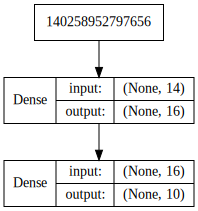

In [6]:
SVG(model_to_dot(model.nn,show_layer_names = False, show_shapes = True).create(prog='dot', format='svg'))

# Testing / Runs

In [7]:
X_test = X_test[:,np.where(model.viu)[0]]
y_test = to_categorical(y_test)
model.score(X_test,y_test)

Input data shape: (594, 14), Output data shape: (594, 10).
Neural Network to test:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 16)                240       
_________________________________________________________________
dense_60 (Dense)             (None, 10)                170       
Total params: 410
Trainable params: 410
Non-trainable params: 0
_________________________________________________________________
594/594 [==============================] - 0s 49us/step
Obtained Network Evaluation Score of: 0.8838383842397619


0.8838383842397619

## Model Train/Test Evaluation

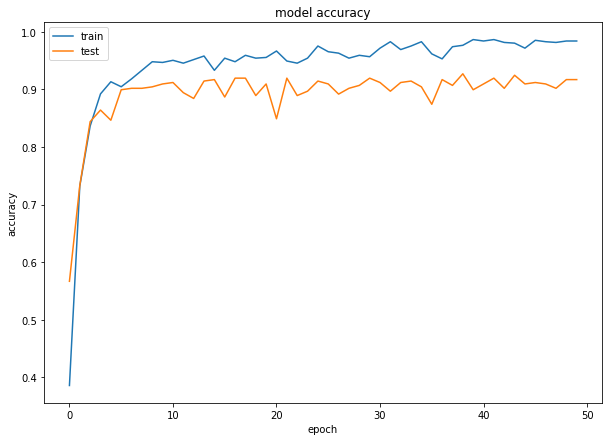

In [8]:
plt.plot(model.nn.history.history['acc'])
plt.plot(model.nn.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

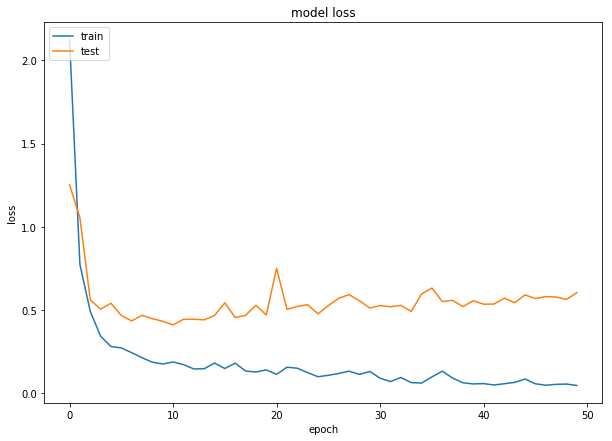

In [9]:
plt.plot(model.nn.history.history['loss'])
plt.plot(model.nn.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Model Nescience analysis

In [10]:
model_hist = pd.DataFrame(model.history)
model_hist = model_hist.reset_index()
model_hist.rename(columns={'index':'NN #'}, inplace=True)
model_hist['h_l_nodes'] = model_hist['layer_sizes'].apply(lambda x: np.sum(x)-x[0]-model.n_classes) #hlayernodes -10 bc 10 outputs, fix later.

model_hist 

,NN #,inaccuracy,layer_sizes,miscoding,nescience,score,surfeit,h_l_nodes
0,0,0.176957,"[8, 8, 10]",1.233407,0.363453,0.811305,0.557936,8
1,1,0.201858,"[9, 8, 10]",1.181921,0.396767,0.783874,0.567839,8
2,2,0.175840,"[9, 9, 10]",1.181921,0.361762,0.817955,0.568285,9
3,3,0.179271,"[9, 10, 10]",1.181921,0.367368,0.813799,0.574061,10
4,4,0.158685,"[9, 11, 10]",1.181921,0.338084,0.832086,0.579487,11
5,5,0.129045,"[10, 11, 10]",1.132165,0.289221,0.868662,0.574651,11
6,6,0.146199,"[10, 12, 10]",1.132165,0.317705,0.853699,0.581580,12
7,7,0.138664,"[11, 12, 10]",1.084051,0.304961,0.862012,0.587128,12
8,8,0.156012,"[11, 13, 10]",1.084051,0.332596,0.842062,0.592509,13
9,9,0.159666,"[12, 13, 10]",1.036740,0.336224,0.842062,0.589981,13


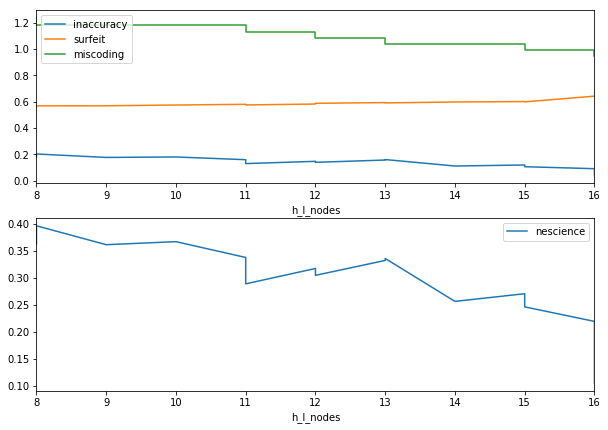

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1)
model_hist.plot(x='h_l_nodes',y=['inaccuracy','surfeit','miscoding'],ax=axes[0])
model_hist.plot(x='h_l_nodes', y=['nescience'],ax=axes[1])

#Pulsar Stars dataset testing

In [15]:
data = genfromtxt('pulsar_stars.csv', delimiter=',')
data = np.delete(data, 0, 0)
X = data[:,:8]
y = data[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("X train :{}. y_Train: {}, X test: {}, y_test: {}".format(X_train.shape,y_train.shape, X_test.shape, y_test.shape))

X train :(12528, 8). y_Train: (12528,), X test: (5370, 8), y_test: (5370,)


In [17]:
model2 = NescienceNeuralNetworkClassifier(niterations = 50, learning_rate = 0.01, verbose = True)
model2.fit(X_train, y_train)

Will start with 1 features out of 8.
Input dimension: 1
[DEBUG] Fitting initial NN.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_87 (Dense)             (None, 2)                 4         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
[DEBUG] Evaluating initial nn...
12528/12528 [==============================] - 0s 27us/step
[DEBUG] Keras-Scores obtained: loss:0.08490178809473874, acc:0.9762931034482759.
12528/12528 [==============================] - 0s 27us/step
[DEBUG] NN Evaluated Accuracy = 0.9762931034482759.
Miscoding:  1.758724012633639 Inaccuracy:  0.025059503570214213 Redundancy:  0.28402366863905326 Nescience:  0.06819042299042372
Run #1.
[DEBUG] Testing adding a new feature 

NescienceNeuralNetworkClassifier(backward=False, compressor='bz2',
                                 learning_rate=None, method='Harmonic',
                                 niterations=None, verbose=True)

In [29]:
# X_test = X_test[:,np.where(model.viu)[0]]
# y_test = to_categorical(y_test)
model2.score(X_test,y_test)

Input data shape: (5370, 3), Output data shape: (5370, 2).
Neural Network to test:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_118 (Dense)            (None, 4)                 16        
_________________________________________________________________
dense_119 (Dense)            (None, 2)                 10        
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________
5370/5370 [==============================] - 0s 33us/step
Obtained Network Evaluation Score of: 0.9698324021236413


0.9698324021236413

In [0]:
def plot_model_acc(model):
    plt.plot(model.nn.history.history['acc'])
    plt.plot(model.nn.history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return

def plot_model_loss(model):
    plt.plot(model.nn.history.history['loss'])
    plt.plot(model.nn.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return

def model_hist(model):
    model_hist = pd.DataFrame(model.history)
    model_hist = model_hist.reset_index()
    model_hist.rename(columns={'index':'NN #'}, inplace=True)
    model_hist['h_l_nodes'] = model_hist['layer_sizes'].apply(lambda x: np.sum(x)-x[0]-model.n_classes) #hlayernodes -10 bc 10 outputs, fix later.
    return model_hist

def vis_nescience(model_hist):
    fig, axes = plt.subplots(nrows=2, ncols=1)
    model_hist.plot(x='h_l_nodes',y=['inaccuracy','surfeit','miscoding'],ax=axes[0])
    model_hist.plot(x='h_l_nodes', y=['nescience'],ax=axes[1])


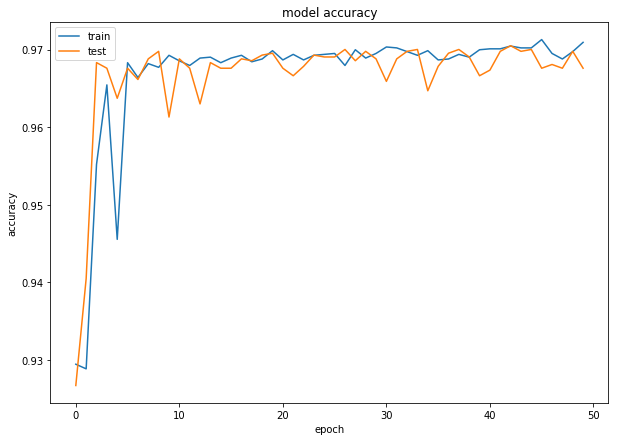

In [39]:
plot_model_acc(model2)

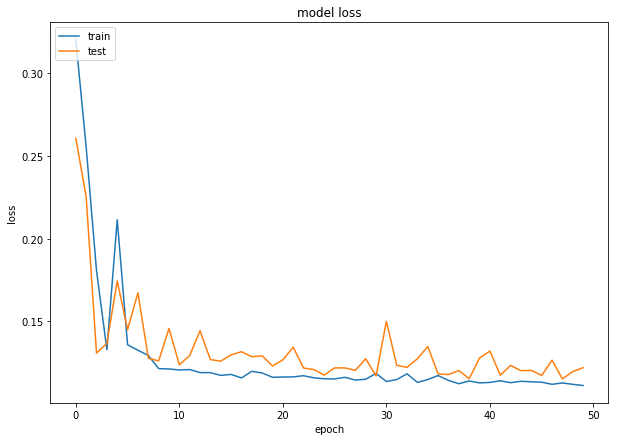

In [34]:
plot_model_loss(model2)

In [35]:
model2_hist = model_hist(model2)
model2_hist

,NN #,inaccuracy,layer_sizes,miscoding,nescience,score,surfeit,h_l_nodes
0,0,0.025060,"[1, 1, 2]",1.758724,0.068190,0.976293,0.284024,1
1,1,0.024412,"[2, 1, 2]",1.252346,0.066454,0.976852,0.295775,1
2,2,0.024240,"[2, 2, 2]",1.252346,0.066547,0.977091,0.330166,2
3,3,0.032674,"[3, 2, 2]",0.772854,0.085896,0.971424,0.330357,2
4,4,0.032891,"[3, 3, 2]",0.772854,0.087227,0.971264,0.370937,3
5,5,0.036617,"[3, 3, 3, 2]",0.772854,0.097006,0.967992,0.430667,6
6,6,0.035716,"[3, 3, 4, 2]",0.772854,0.095189,0.968790,0.449640,7


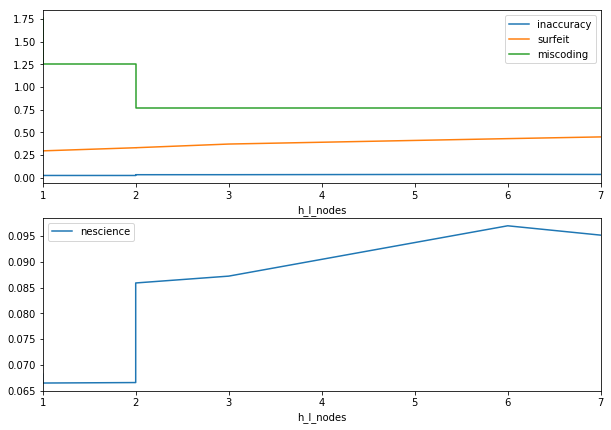

In [36]:
vis_nescience(model2_hist)

#Digits dataset testing
*+ testing with updated visualization functions*

In [64]:
#test with updated functions for analysis/visualization
from sklearn.datasets import load_digits
data = load_digits()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

model3 = NescienceNeuralNetworkClassifier(niterations = 50, learning_rate = 0.01, verbose = True)
model3.fit(X_train, y_train)

Will start with 8 features out of 64.
Input dimension: 8
[DEBUG] Fitting initial NN.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_226 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_227 (Dense)            (None, 10)                90        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
[DEBUG] Evaluating initial nn...
1203/1203 [==============================] - 0s 60us/step
[DEBUG] Keras-Scores obtained: loss:0.917636444493323, acc:0.6699916875471399.
1203/1203 [==============================] - 0s 43us/step
[DEBUG] NN Evaluated Accuracy = 0.6699916875471399.
Miscoding:  1.23717370026772 Inaccuracy:  0.29700142789148026 Redundancy:  0.5585664335664335 Nescience:  0.502885013158333
Run #1.
[DEBUG] Testing adding a new feature to cnn

NescienceNeuralNetworkClassifier(backward=False, compressor='bz2',
                                 learning_rate=None, method='Harmonic',
                                 niterations=None, verbose=True)

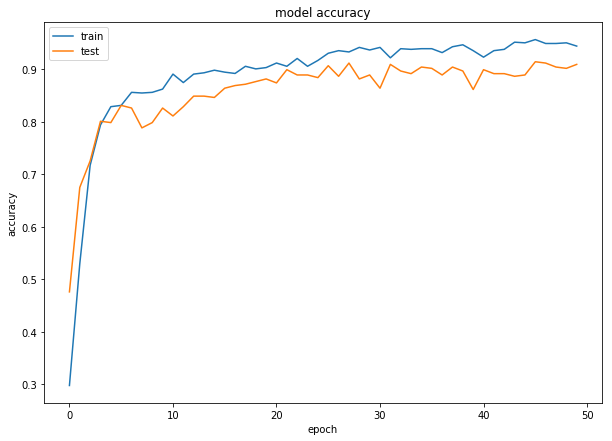

In [65]:
model3.plot_model_acc()

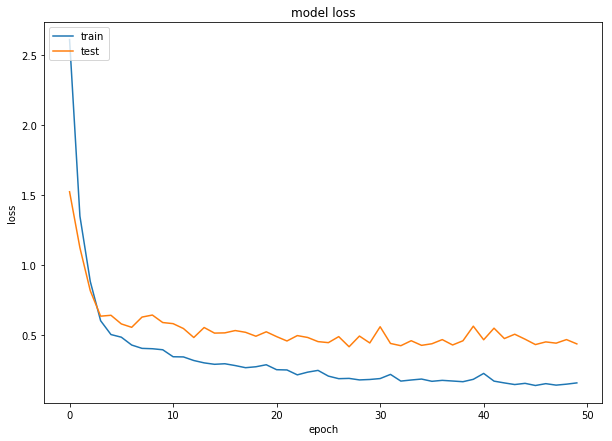

In [66]:
model3.plot_model_loss()

In [74]:
 def model_hist(model): #solve issue with class function not working ?
        model_hist = pd.DataFrame(model.history)
        model_hist = model_hist.reset_index()
        model_hist.rename(columns={'index':'NN #'}, inplace=True)
        model_hist['h_l_nodes'] = model_hist['layer_sizes'].apply(lambda x: np.sum(x)-x[0]-model.n_classes) 
        return model_hist
    
model3_hist = model_hist(model3)
model3_hist


,NN #,inaccuracy,layer_sizes,miscoding,nescience,score,surfeit,h_l_nodes
0,0,0.297001,"[8, 8, 10]",1.237174,0.502885,0.669992,0.558566,8
1,1,0.308418,"[9, 8, 10]",1.186337,0.510007,0.665004,0.556485,8
2,2,0.238674,"[9, 9, 10]",1.186337,0.439240,0.738986,0.556414,9
3,3,0.164148,"[10, 9, 10]",1.136313,0.343904,0.830424,0.571012,9
4,4,0.186620,"[10, 10, 10]",1.136313,0.375653,0.801330,0.572221,10
5,5,0.158399,"[11, 10, 10]",1.086820,0.334422,0.837905,0.575564,10
6,6,0.149284,"[11, 11, 10]",1.086820,0.321349,0.848712,0.582450,11
7,7,0.150073,"[12, 11, 10]",1.041660,0.321359,0.847049,0.584133,11
8,8,0.170098,"[12, 12, 10]",1.041660,0.351469,0.823774,0.589407,12
9,9,0.132505,"[13, 12, 10]",0.999169,0.293144,0.868662,0.593066,12


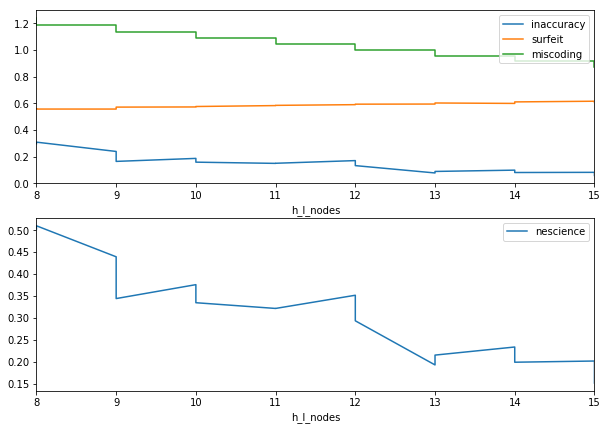

In [75]:
model3.vis_nescience(model3_hist)